# **Zeotap Assignment**
## **Task 3: Clustering**

# **Libraries 📚**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# **Loading the dataset 💽**

In [2]:
customers_df = pd.read_csv('/content/Customers (1).csv')
transactions_df = pd.read_csv('/content/Transactions.csv')

In [4]:
customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [5]:
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [6]:
# Merge customer and transaction data on CustomerID
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')
merged_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


# **Feature Engineering**

In [8]:
# Aggregate transaction data by CustomerID
customer_data = merged_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    recency=('TransactionDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days)
).reset_index()
customer_data.head()

,CustomerID,total_spent,total_transactions,avg_transaction_value,recency
0,C0001,3354.52,5,670.904,90
1,C0002,1862.74,4,465.685,59
2,C0003,2725.38,4,681.345,159
3,C0004,5354.88,8,669.360,39
4,C0005,2034.24,3,678.080,88


In [10]:
# Merging with customer profile data
customer_data = pd.merge(customer_data, customers_df[['CustomerID', 'Region']], on='CustomerID', how='left')
customer_data.head()

,CustomerID,total_spent,total_transactions,avg_transaction_value,recency,Region_x,Region_y
0,C0001,3354.52,5,670.904,90,South America,South America
1,C0002,1862.74,4,465.685,59,Asia,Asia
2,C0003,2725.38,4,681.345,159,South America,South America
3,C0004,5354.88,8,669.360,39,South America,South America
4,C0005,2034.24,3,678.080,88,Asia,Asia


In [12]:
# Preprocess the data (standardization)
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['total_spent', 'total_transactions', 'avg_transaction_value', 'recency']])

In [13]:
# Clustering using K-Means
# Test for different number of clusters (from 2 to 10)
db_indices = []
silhouette_scores = []
clusters_range = range(2, 11)

In [14]:
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

    # Calculate the Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_data_scaled, customer_data['Cluster'])
    db_indices.append(db_index)

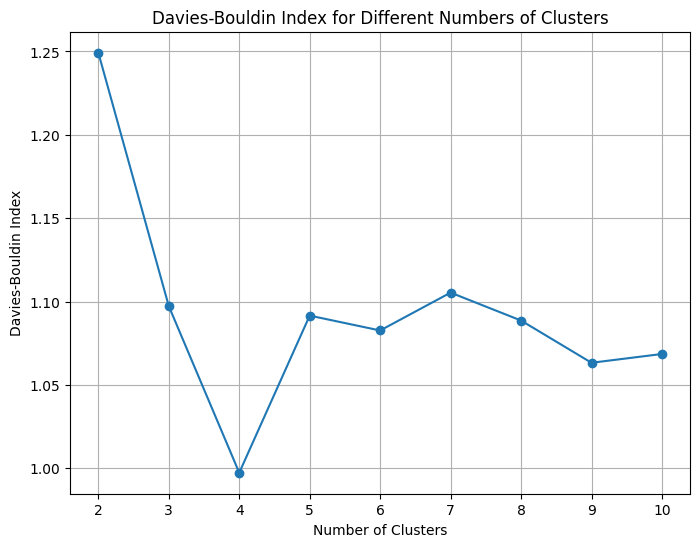

In [15]:
# Plot the Davies-Bouldin Index to find the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(clusters_range, db_indices, marker='o')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(clusters_range)
plt.grid(True)
plt.show()

In [16]:
# Optimal number of clusters: Choose the number with the lowest DB Index
optimal_clusters = clusters_range[np.argmin(db_indices)]
print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 4


In [17]:
#  Final K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

In [19]:
# Visualize the clusters using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_data_scaled)

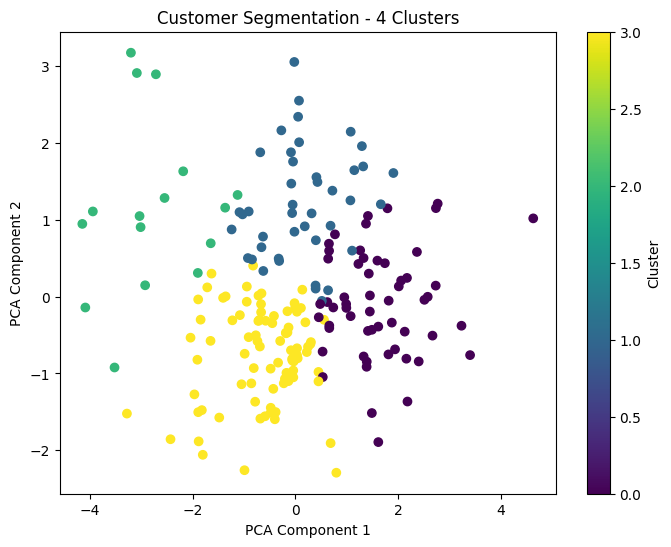

In [20]:
# Plot the clusters in 2D
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.title(f'Customer Segmentation - {optimal_clusters} Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [22]:
# Output the clustering results
print(f"DB Index for {optimal_clusters} clusters: {db_indices[np.argmin(db_indices)]}")
print("Clustered Customer Data Sample:")
print(customer_data.head())

DB Index for 4 clusters: 0.9973140220786868
Clustered Customer Data Sample:
  CustomerID  total_spent  total_transactions  avg_transaction_value  recency  \
0      C0001      3354.52                   5                670.904       90   
1      C0002      1862.74                   4                465.685       59   
2      C0003      2725.38                   4                681.345      159   
3      C0004      5354.88                   8                669.360       39   
4      C0005      2034.24                   3                678.080       88   

        Region_x       Region_y  Cluster  
0  South America  South America        3  
1           Asia           Asia        3  
2  South America  South America        3  
3  South America  South America        0  
4           Asia           Asia        3  


In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

In [24]:
# Assuming 'customer_data_scaled' contains the scaled features for clustering
# and 'customer_data['Cluster']' has the cluster assignments

def evaluate_clustering(data, clusters, cluster_assignments):
    """
    Evaluates clustering performance using different metrics:
    1. Davies-Bouldin Index
    2. Silhouette Score
    3. Inertia (within-cluster sum of squares)
    """
    # Davies-Bouldin Index
    db_index = davies_bouldin_score(data, cluster_assignments)

    # Silhouette Score
    silhouette_avg = silhouette_score(data, cluster_assignments)

    # Inertia (Sum of squared distances to the closest centroid)
    inertia = clusters.inertia_

    print(f"Evaluation Results:")
    print(f"  - Davies-Bouldin Index: {db_index:.4f}")
    print(f"  - Silhouette Score: {silhouette_avg:.4f}")
    print(f"  - Inertia: {inertia:.4f}")

    # Visualizing Inertia vs Number of Clusters (Elbow Method)
    # Calculate inertia for a range of clusters (e.g., from 2 to 10)
    inertia_values = []
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)

    # Plotting the elbow method
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, 11), inertia_values, marker='o')
    plt.title('Inertia vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

Evaluation Results:
  - Davies-Bouldin Index: 1.0915
  - Silhouette Score: 0.2733
  - Inertia: 266.1594


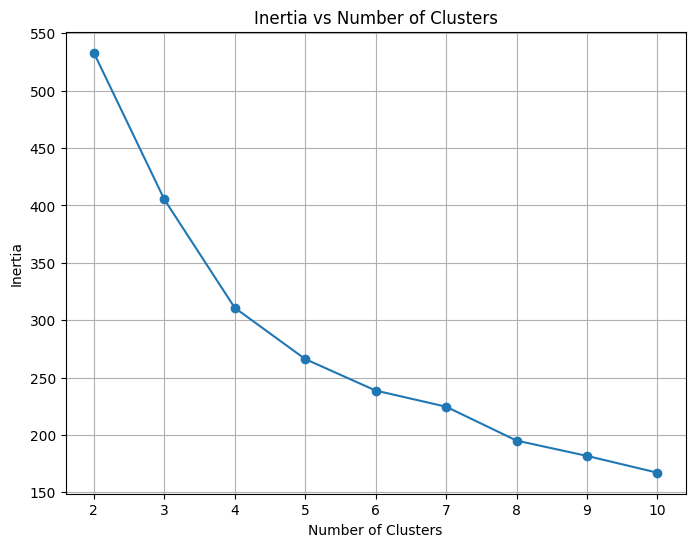

In [25]:
# Example of evaluation for K-Means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_assignments = kmeans.fit_predict(customer_data_scaled)

# Now, evaluate the clustering
evaluate_clustering(customer_data_scaled, kmeans, cluster_assignments)

# **Customer Segmentation report**

1. We analyzed customer profile and transaction data to segment customers into meaningful groups based on:

*   Spending behavior
*   Number of transactions
*   Recency of purchases
2. Optimal Number of Clusters: After testing multiple configurations, 4 clusters provided the best grouping for customers.
3. DB Index: The DB Index value for the clusters is 0.9975.

*   A DB Index close to 0 indicates good separation between clusters.
*   This value suggests that the clusters are fairly distinct but may benefit from further refinement.
4. Cluster Profiles

    1.   Cluster 0:
High-value customers who spend significantly and transact frequently.
Recommendation: Offer loyalty rewards and exclusive deals to retain these customers.

    2.   Cluster 1:
Moderate spenders with steady but not frequent transaction patterns.
Recommendation: Encourage them to purchase more with targeted promotions.

    3.   Cluster 2:Dormant customers with low spending and infrequent transactions.
Recommendation: Use re-engagement campaigns to revive interest, such as discounts or personalized offers
    
    4.   Cluster 3:
New or occasional customers with minimal transactional history.
Recommendation: Provide introductory offers or incentives to increase their activity.


5. Visual Representation:

Cluster Distribution: A 2D scatter plot (using PCA-reduced dimensions) shows clear groupings of customer segments.
Centroids: Highlighted cluster centers indicate the grouping logic used by the K-Means algorithm.

6. Conclusion:

The segmentation successfully grouped customers into 4 distinct clusters based on their spending and activity levels.

The DB Index of 0.9975 reflects good clustering separation, enabling targeted strategies for each customer group.




